In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import *
from math import pi, cos, exp, floor
from scipy.signal import StateSpace, impulse2, lsim2

In [ ]:
var = np.array([i*20 for i in range(10)])
j2 = [i for i in var if i >= 60]
j2

In [2]:
class MOLIwhiteBox:
    def __init__(self,method):
        self.C = np.array([0, 0, 0, 1])
        self.A = np.zeros([4,4])
        if method is None:
            method = 'trivial'
        self.filter = method
        
    def describe(self):
        print('This is a MOLI white Box alertness model')
    def structure(self):
        if self.filter == 'trivial':
            w = pi/12
            tau = 28.12
            self.A[1,3] = -w**2
            self.A[2,3] = -w**2/tau
            self.A[3,3] = -1/tau
    
    def fit(self,timeSamp,u,y):
        A_ = np.transpose(self.A)
        C_ = np.transpose(self.C)
        I_ = np.identity(4)
        sFilt = StateSpace(A_,C_,I_,[])
        regres = np.array([])
        
        for i in range(u.shape[1]):
            impT, impResp = impulse2(sFilt, 0, timeSamp.iloc[i,:])
            outT, outResp = lsim2(sFilt, u.iloc[i,:], timeSamp.iloc[i,:])
            
            comp = np.zeros([u.shape[0],4*u.shape[1]])
            comp[:,4*i:4*(i+1)] = impResp[:,:]
            
            aux = np.concatenate((outResp,comp))
            regres = np.concatenate((regres,aux),1)
        
        _y = y.reshape([u.shape[0]*u.shape[1],1])
        theta = np.linalg.tensorsolve(regres,_y)
        
        self.L = theta[:3]
        for i in range(u.shape[1]):
            init = 3*i
            final = 3*i + 4
            self.B[:,i] = theta[init:final]

In [55]:
class simAlert:
    def __init__(self,numDays):
        self.days = numDays
        self.time = pd.DataFrame()
        self.levAl = pd.DataFrame()
        self.levHom = pd.DataFrame()
        self.omega = pi/12.0
        self.tau = 28.33
        self.M = 2.52
        self.phi = -4.41
        self.DC = 2.40
        self.y_ = 14.3
        self.tau_e = 2.6247
    
    def generate(self,windowDecision,resolution):
        initAl = 15.3
        self.resolution = resolution
        self.windows = windowDecision
        for i in range(self.days):
            unTime = [24*i + 24*j/self.resolution for j in range(10000)]
            wTime = [j - 24*i for j in unTime if (j - 24*i) <= windowDecision[i]]
            sTime = [j - 24*i - windowDecision[i] for j in unTime 
                     if (j - 24*i) >= windowDecision[i]]
            
            circadian = [self.M*cos(self.omega*k + self.phi) for k in unTime]
            wHom = [(initAl - self.DC)*exp(-k/self.tau) + self.DC for k in wTime]
            sHom = [self.y_*(1-exp(-k/self.tau_e)) + wHom[-1]*exp(-k/self.tau_e) 
                    for k in sTime]
            Hom = np.concatenate((wHom,sHom))
            
            self.levHom.loc[:,i] = Hom
            self.levAl.loc[:,i] = circadian + Hom
            self.time.loc[:,i] = unTime
            initAl = Hom[-1]
    
    def randSample(self,seed,ppH):
        
        size_ = floor(max(self.windows)*ppH) + 1
        
        self.sAl = np.zeros([size_,self.days])
        self.sT = np.zeros([size_,self.days])
        
        for i in range(self.days):
            step = floor(self.resolution/(self.windows[i]*ppH))
            samples = range(0,self.resolution,step)
            spH = floor(self.resolution/self.windows[i])
            cruzeArr = [k - floor(spH/4) for k in range(0,floor(spH/2),1)]
            cruzeInc = sample(cruzeArr, len(samples))
            if cruzeInc[0] < 0:
                cruzeInc[0] = 0
            if cruzeInc[-1] > 0:
                cruzeInc[-1] = 0
            samples_inc = np.asarray(cruzeInc) + samples
            size_ = samples_inc.shape[0]
            
            self.sAl[0:size_,i] = self.levAl.loc[samples_inc,i].values
            self.sT[0:size_,i] = self.time.loc[samples_inc,i].values
            self.ind = size_
            

In [56]:
alertData = simAlert(2)
alertData.generate([16,16], 10000)
alertData.randSample(15,2)
print(alertData.sAl)

[[14.15343552 13.29268625]
 [13.89470452 12.38253738]
 [13.03207541 11.66736334]
 [12.23883425 11.1954526 ]
 [11.7294249  10.71676514]
 [11.27715329 10.42685543]
 [10.84324048  9.79833709]
 [10.6579561   9.6962527 ]
 [10.41574522  9.47965929]
 [10.34945584  9.39397971]
 [10.38160353  9.41401396]
 [10.41115332  9.61748778]
 [10.54017515  9.72075926]
 [10.87836885 10.05240791]
 [11.17720093 10.2474003 ]
 [11.42215641 10.53493217]
 [11.66360581 10.91682148]
 [11.84240476 11.14625383]
 [11.99017736 11.25993708]
 [12.12498999 11.47085465]
 [12.22745087 11.50868851]
 [12.23275889 11.52267439]
 [13.28383471 12.15077927]
 [14.14134509 13.27263544]
 [14.32116129 14.24092554]
 [14.76308449 14.632383  ]
 [15.02854095 14.80042695]
 [14.96996537 14.79823681]
 [14.71130369 14.73497495]
 [14.63748649 14.5628055 ]
 [14.19103789 14.13885426]
 [13.90035702 13.8041604 ]
 [13.35388411 13.32056955]]


In [57]:
print(alertData.sT)

[[ 0.3696 24.0384]
 [ 0.6168 24.9456]
 [ 1.488  25.7256]
 [ 2.3904 26.2944]
 [ 3.06   26.9424]
 [ 3.7608 27.3888]
 [ 4.62   28.6488]
 [ 5.1072 28.9344]
 [ 6.1008 29.7936]
 [ 6.8208 30.9216]
 [ 7.6992 31.3248]
 [ 7.9488 32.5608]
 [ 8.6688 32.9568]
 [ 9.9    33.9912]
 [10.788  34.5264]
 [11.4888 35.2872]
 [12.2064 36.3336]
 [12.792  37.0512]
 [13.3536 37.4664]
 [14.0136 38.5632]
 [14.9688 38.9496]
 [15.3768 39.6288]
 [16.6728 40.3248]
 [17.4288 41.0352]
 [17.64   41.9856]
 [18.3528 42.66  ]
 [19.8144 43.1904]
 [20.3016 44.5368]
 [21.2304 44.8248]
 [21.4248 45.3888]
 [22.4064 46.3896]
 [22.9632 47.0544]
 [23.9616 47.9616]]


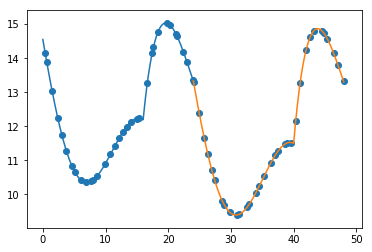

In [59]:
plt.plot(alertData.time,alertData.levAl)
plt.scatter(alertData.sT,alertData.sAl)